# **Model Training and Evaluation**

<p style="text-align: center;">
    <img style="width: 35%; height: 20%; float: left;" src="../assets/images/model_training.jpg" alt="Model Training image">
</p>

## Objectives

* Accomplish second business requirement:

  _**"The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew"**_

## Inputs Required

* Image data will be sourced from the following directories and their subfolders:

  - **Training Images**: inputs/cherry_leaves_dataset/cherry-leaves/train
  - **Validation Images**: inputs/cherry_leaves_dataset/cherry-leaves/validation
  - **Test Images**: inputs/cherry_leaves_dataset/cherry-leaves/test 

* av_image_shape.pkl file from outputs/version folder

## Generated Outputs

1. Images distribution plot in train, validation, and test set.
2. Image augmentation.
3. Class indices to change prediction inference in labels.
4. Optimal best Hyperparameters.
5. Machine learning model creation and training.
6. Saved best model.
7. Learning curve plot for model performance.
8. Model evaluation on pickle file.
9. Prediction on the random image file.


---

# Set up the working environment

In [1]:
import os
import joblib
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("\033[92mLibraries Imported Successfully!\033[0m")

Libraries Imported Successfully!


**Important libraries and packages required for model creation:**

In [2]:
! pip install keras-tuner

In [3]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from keras.regularizers import l2
print("\033[92mLibraries Imported Successfully!\033[0m")

Libraries Imported Successfully!


# Change working directory

* To maintain a straightforward folder structure for the application, we must navigate from the current folder to its parent folder by using `os.getcwd()` to access the current directory.

In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/mildew-detection-in-cherry-leaves/jupyter_notebooks'

* To update the current directory to its parent directory, follow these steps:

  * Use `os.path.dirname()` to obtain the parent directory.
  * Utilize `os.chdir()` to set the new current directory to the parent directory.

In [5]:
os.chdir(os.path.dirname(current_dir))
print(f"\033[92mYou set a new current directory\033[0m")

You set a new current directory


* Confirm the new current directory.

In [6]:
new_current_dir = os.getcwd()
new_current_dir

'/workspaces/mildew-detection-in-cherry-leaves'

# Set input and output directory paths

**Inputs**

In [7]:
data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = data_dir + '/train'
validation_path = data_dir + '/validation'
test_path = data_dir + '/test'

**Outputs**

In [8]:
version = 'V_1'

file_path = f'outputs/{version}'
version_file_path = os.path.join(new_current_dir, file_path)

if os.path.exists(version_file_path):
    # check version file path exists, if not creates a new directory.
     print(f"\033[91mVersion {version} already exists. Create a new version please! \033[0m")
     pass
else:
    os.makedirs(name=file_path)
    print(f"\033[92mVersion {version} created successfully! \033[0m")

Version V_1 already exists. Create a new version please! 


# Set label names

In [9]:
labels = os.listdir(train_path)
print('Labels for the images are:', labels)

Labels for the images are: ['healthy', 'powdery_mildew']


# Set image shape

In [10]:
# Import saved image shape embedding
version = 'V_1'
image_shape = joblib.load(filename=f"outputs/{version}/av_image_shape.pkl")
image_shape

(256, 256, 3)

---

# Generating image distribution and count for different sets and labels.

Train set:
 train         healthy  1472
 train  powdery_mildew  1472


Validation set:
 validation         healthy  210
 validation  powdery_mildew  210


Test set:
 test         healthy  422
 test  powdery_mildew  422




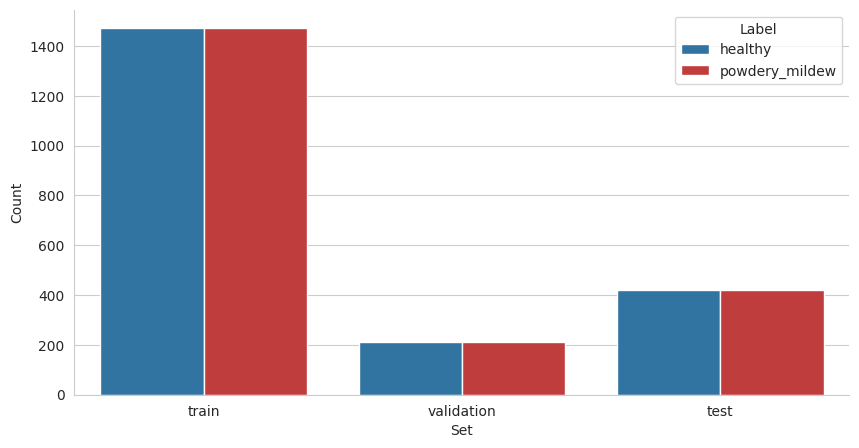

In [11]:
def get_image_count(folder, label):
    """
    Function to get image count for each label in a specific set
    and plot image data distribution.
    """
    try:
        return len(os.listdir(os.path.join(data_dir, folder, label)))
    except:
        return None

# Create a DataFrame to store the image distribution and count per set and label
sets = ['train', 'validation', 'test']
labels = ['healthy', 'powdery_mildew']
data = {
    'Set': [],
    'Label': [],
    'Count': []
}

for folder in sets:
    for label in labels:
        count = get_image_count(folder, label)
        data['Set'].append(folder)
        data['Label'].append(label)
        data['Count'].append(count)

df_freq = pd.DataFrame(data)

# Print the image distribution and count per set and label
for folder in sets:
    print(f"\033[1m{folder.capitalize()} set:\033[0m")
    print(df_freq[df_freq['Set']==folder].to_string(index=False, header=False, justify='center'))
    print("\n")

# Plot the image distribution and count per set and label using Seaborn
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
sns.barplot(data=df_freq, x='Set', y='Count', hue='Label', palette=['#1f77b4', '#d62728'])
sns.despine()
plt.savefig(f'{file_path}/img_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

**Interpretation & Insights:**

* In the bar plot representation, the 'healthy' category is indicated by the blue bars, while the 'powdery mildew' category is represented by the red bars.
* Within the train dataset, a majority of the data is contained, comprising a total of 2944 image data files. This substantial portion is further segregated into subfolders, with 'healthy' and 'powdery mildew' categories each containing 1472 image files.
* The validation set consists of 420 image data files, equally divided into subfolders containing 210 files each for 'healthy' and 'powdery mildew.'
* Likewise, the test set encompasses 844 image data files, and these, too, are evenly distributed into subfolders, with 422 files in each category.

The visualization provides a comprehensive overview of the dataset distribution across different subsets. This meticulous data distribution adheres to the prescribed 70-10-20 split ratio for training, validation, and testing.

---

# Image Data Augmentation

As observed from the metrics above, the dataset is relatively small when compared to large-scale image datasets commonly used for training CNNs. Despite its size, training a CNN with this dataset is possible, but it may be prone to overfitting. To address this issue, we will employ data augmentation techniques to artificially expand the training set.

In [12]:
# Create an ImageDataGenerator for data augmentation
augmented_image_data = ImageDataGenerator(
    rotation_range=20,        # Random rotation up to 20 degrees
    width_shift_range=0.1,    # Randomly shift images horizontally by 10% of the total width
    height_shift_range=0.1,   # Randomly shift images vertically by 10% of the total height
    shear_range=0.1,          # Apply shear transformation with maximum shear of 0.1
    zoom_range=0.20,           # Randomly zoom images by up to 20%
    horizontal_flip=True,     # Randomly flip images horizontally
    vertical_flip=True,       # Randomly flip images vertically
    fill_mode='nearest',      # Fill points outside the input boundaries using the nearest pixel value
    rescale=1./255            # Rescale pixel values to the range [0, 1]
)

* Setting batch size, color mode, and class mode for image data generator.

In [13]:
batch_size = 32
data_color_mode = 'rgb'
data_class_mode = 'binary'

## Augment Training Dataset Images

In [14]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                               color_mode=data_color_mode,
                                               batch_size=batch_size,
                                               class_mode=data_class_mode,
                                               shuffle=True
                                               )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Augment Validation Dataset Images

In [15]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode=data_color_mode,
                                                                        batch_size=batch_size,
                                                                        class_mode=data_class_mode,
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Augment Test Dataset Images

In [16]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode=data_color_mode,
                                                                  batch_size=batch_size,
                                                                  class_mode=data_class_mode,
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot Augmented Image

In [17]:
def plot_augmented_images(dataset_name, dataset, display_size=3):
    """
    Plot augmented images from the given dataset.
    """

    # Display the number of augmented images
    for _ in range(display_size):
        # Get the next batch of images and corresponding labels
        img, label = dataset.next()

        # Display the image
        plt.imshow(img[0])  # Selecting the first image from the batch
        plt.axis('off')     # Turn off axis ticks and labels
        plt.title(f"{dataset_name} - Augmented Image")
        plt.show()

* ## Training Image Set

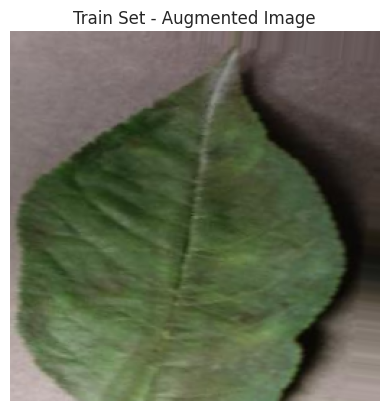

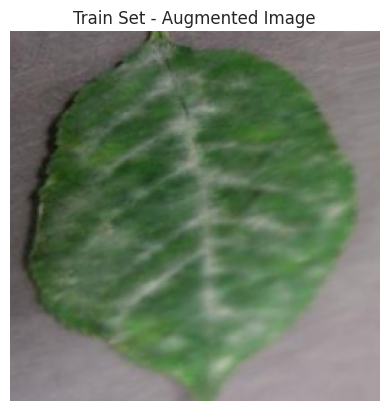

In [18]:
plot_augmented_images("Train Set", train_set, display_size=2)

* ## Validation Image Set

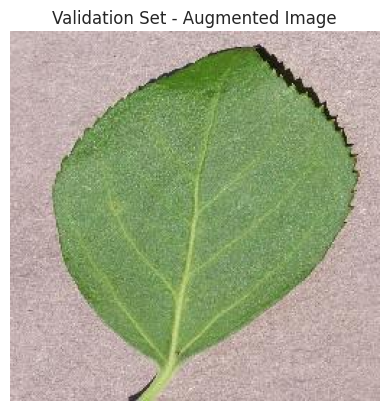

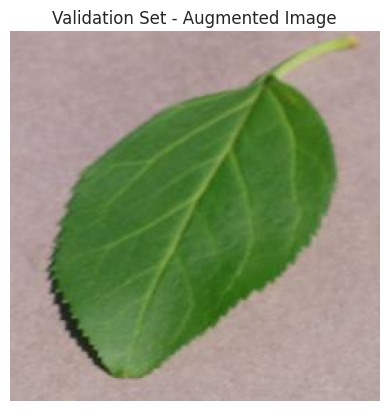

In [19]:
plot_augmented_images("Validation Set", validation_set, display_size=2)

* ## Test Image Set

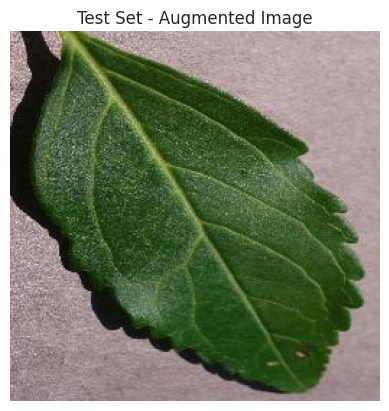

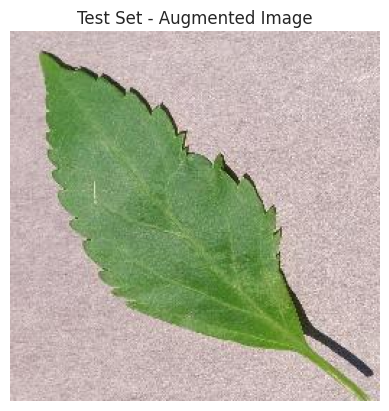

In [20]:
plot_augmented_images("Test Set", test_set, display_size=2)

Save the class indices for both the labels into a pickle file.

In [21]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")
train_set.class_indices

{'healthy': 0, 'powdery_mildew': 1}

---

# CNN ML Model Creation

For the image classification task, we employ a Convolutional Neural Network (CNN) as the model of choice. This CNN is specifically designed to learn and identify the predominant feature, which in this case is the powdery mildew, from the pre-labeled cherry leaf images.

### Function to create the model.

The objective of the function `create_model` is to construct model with different hyperparameter configurations for hyperparameter optimization. The aim is to create a compact and accurate model tailored for the specific task at hand.

The model architecture comprises a sequence of `Conv2D (convolutional layers)` followed by `MaxPooling2D (max pooling layers)`, which reduce the spatial dimensions of the output feature maps. The number of filters in the convolutional layers progressively increases from 12 to 36 in each subsequent layer. The activation function employed in these convolutional layers is `ReLU`, introducing non-linearity to the network.

Following the convolutional layers, the output feature maps are `Flatten (flattened)` and inputted into a fully connected (dense) layer. The number of units in this `Dense layer` is determined by the hyperparameter called 'tune_units,' using the 'hp.Int' method. This hyperparameter search technique allows the network to explore different numbers of units for the dense layer to find the optimal value. The activation function utilized in the dense layer is also ReLU.

To mitigate overfitting, a dropout layer with a rate of 0.5 is introduced after the dense layer. The output layer employs the `tanh` activation function, which is a suitable alternative to sigmoid for binary classification tasks. Additionally, the learning rate utilized for training the network is a hyperparameter chosen through the 'learning_rate' variable using the 'hp.Choice' method. The `Adam` optimizer is employed to minimize the binary cross-entropy loss function.

In [22]:
def create_model(hp):

    # Define a Sequential model    
    model = Sequential()

    # Add a convolutional layer with 12 filters, a kernel size of 3x3, and 'relu' activation function
    model.add(Conv2D(filters=12, kernel_size=(3,3), input_shape=image_shape, activation='relu'))
    # Add a max pooling layer with a pool size of 2x2
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Add another convolutional layer with 24 filters, a kernel size of 3x3, and 'relu' activation function
    model.add(Conv2D(filters=24, kernel_size=(3,3), input_shape=image_shape, activation='relu'))
    # Add another max pooling layer with a pool size of 2x2
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Add another convolutional layer with 36 filters, a kernel size of 3x3, and 'relu' activation function
    model.add(Conv2D(filters=36, kernel_size=(3,3), input_shape=image_shape, activation='relu'))
    # Add another max pooling layer with a pool size of 2x2
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Flatten the output matrix from the convolutional layers into a vector 
    model.add(Flatten())

    # Tune number of units in Dense layer
    opt_units = hp.Int('units', min_value=16, max_value=128, step=16)

    # Add a dense layer with tune_units and tune_activation function
    model.add(Dense(units=opt_units, activation='relu', kernel_regularizer=l2(0.001)))

    # Add a dropout layer with a rate of 0.5
    model.add(Dropout(0.5))
    # Add a dense output layer with 1 unit and 'sigmoid' activation function
    model.add(Dense(units=1, activation='tanh'))

    # Define the learning rate and compile the model
    opt_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=opt_learning_rate),
        loss="binary_crossentropy",  
        metrics=["accuracy"],
    )

    return model
    

Hyperparameter tuning will be performed using the Hyperband tuner, which has been chosen due to its fast processing speed, early stopping capability, and efficient resource utilization. The Hyperband tuner is well-suited for optimizing the hyperparameters of the model by iteratively training different configurations and discarding unpromising ones. Its ability to make intelligent early stopping decisions ensures that only the most promising hyperparameter configurations are explored further, making the tuning process efficient and effective.

* Hyperband is a more advanced hyperparameter optimization technique that uses a combination of random search and early stopping.

In [23]:
tuner = kt.Hyperband(create_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory=file_path,
                     project_name='hypertuning'
                     )

2023-09-13 20:57:40.312724: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


* Define callbacks

  * `Model Checkpointing`: allows to save the model's weights or the entire model to disk at certain intervals or when specific conditions are met (e.g., the validation accuracy improves). This is essential to save the best model so that it can be used later for predictions or further training.
  * `Early Stopping`: The EarlyStopping callback is used to stop the training process early when the model's performance on a validation metric stops improving or starts degrading. This helps prevent overfitting and saves time by terminating training when further improvement is unlikely.

In [24]:
# Define the EarlyStopping callback to monitor validation loss, stop after 4 epochs with no improvement, and restore the weights of the best model
early_stop = EarlyStopping(monitor='val_loss',
                           patience=4,
                           verbose=1,
                           mode='min',
                           restore_best_weights=True
                           )
# Define the ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath=os.path.join(file_path, 'best_ml_model.h5'),
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1
                             )

* Search optimal hyperparameters

In [25]:
tuner.search(train_set,
             epochs=15,
             steps_per_epoch=len(train_set.classes) // batch_size,
             validation_data=validation_set,
             callbacks=[early_stop, checkpoint],
             verbose=2)

Trial 18 Complete [00h 12m 00s]
val_accuracy: 0.9952380657196045

Best val_accuracy So Far: 0.9952380657196045
Total elapsed time: 01h 28m 04s

Search: Running Trial #19

Value             |Best Value So Far |Hyperparameter
128               |80                |units
0.001             |0.001             |learning_rate
4                 |4                 |tuner/epochs
0                 |2                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/4


KeyboardInterrupt: 

In [27]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display the results of the hyperparameter search
print("The hyperparameter search is completed!")
print("After exploring various configurations, the best model has been found.")

# Get the best hyperparameters
best_units = best_hyperparameters.get('units')
best_lr = best_hyperparameters.get('learning_rate')

# Format and print the results
print(f"The optimal number of units in the first densely-connected layer is \033[1m{best_units}\033[0m.")
print(f"The optimal learning rate for the optimizer is \033[1m{best_lr:.4f}\033[0m.")  # Round to 4 decimal places
print("Now we can use these hyperparameters to train the final model.")

The hyperparameter search is completed!
After exploring various configurations, the best model has been found.
The optimal number of units in the first densely-connected layer is 80.
The optimal learning rate for the optimizer is 0.0010.
Now we can use these hyperparameters to train the final model.


* Create model using best optimal hyperparameters

In [28]:
model = tuner.hypermodel.build(best_hyperparameters)

* Model Summary

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 12)      336       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 12)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 24)      2616      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 24)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 36)        7812      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 36)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32400)            

**Interpretation:**

* The provided summary represents a sequential model architecture designed for data analysis. 
* It consists of various layers, such as convolutional, pooling, and dense layers, flatten and dropout that transform input data and train the model.
* The model has a total of 2,602,925 parameters, which contribute to its ability to learn from data. This is a big number of data to achieve excellent results for our model.
* This architecture aims to process visual information and make predictions, making it a valuable tool for understanding patterns within images.

* Fit the model 

In [30]:
model.fit(train_set,
          epochs=20,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop, checkpoint],
          verbose=1)

Epoch 1/20
92/92 [==============================] - 126s 1s/step - loss: 2.0955 - accuracy: 0.6250 - val_loss: 0.2183 - val_accuracy: 0.9952

Epoch 00001: val_accuracy improved from -inf to 0.99524, saving model to outputs/V_1/best_ml_model.h5
Epoch 2/20
92/92 [==============================] - 123s 1s/step - loss: 0.2795 - accuracy: 0.9606 - val_loss: 0.3027 - val_accuracy: 0.9881

Epoch 00002: val_accuracy did not improve from 0.99524
Epoch 3/20
92/92 [==============================] - 128s 1s/step - loss: 0.2356 - accuracy: 0.9586 - val_loss: 0.2228 - val_accuracy: 0.9905

Epoch 00003: val_accuracy did not improve from 0.99524
Epoch 4/20
92/92 [==============================] - 125s 1s/step - loss: 0.1502 - accuracy: 0.9857 - val_loss: 0.2383 - val_accuracy: 0.9905

Epoch 00004: val_accuracy did not improve from 0.99524
Epoch 5/20
92/92 [==============================] - 128s 1s/step - loss: 0.1369 - accuracy: 0.9868 - val_loss: 0.1409 - val_accuracy: 0.9857

Epoch 00005: val_accura

---